# Load Packages and Dataset

In [1]:
import pandas as pd
import warnings
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from joblib import dump
warnings.filterwarnings("ignore")

drive.mount('/content/drive/')

df = pd.read_csv("/content/drive/My Drive/Dataset/train (1).csv")
test = pd.read_csv("/content/drive/My Drive/Dataset/test (1).csv")

df.head()

Mounted at /content/drive/


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


# Data Understanding

In [2]:
df.shape

(750000, 18)

In [3]:
def summary(df):
    summry = pd.DataFrame(df.dtypes, columns=['data type'])
    summry['missing'] = df.isnull().sum().values
    summry['Duplicate'] = df.duplicated().sum()
    summry['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summry['min'] = desc['min'].values
    summry['max'] = desc['max'].values
    summry['avg'] = desc['mean'].values
    summry['std dev'] = desc['std'].values
    summry['top value'] = desc['top'].values
    summry['Freq'] = desc['freq'].values

    return summry

summary(df).style.set_caption("**Summary Data**").\
background_gradient(cmap='Pastel2_r', axis=0). \
set_properties(**{'border': '1.3px dotted', 'color': '', 'caption-side': 'left'})

,data type,missing,Duplicate,#unique,min,max,avg,std dev,top value,Freq
id,int64,0,0,750000,0.000000,749999.000000,374999.500000,216506.495284,nan,nan
age,int64,0,0,78,18.000000,95.000000,40.926395,10.098829,nan,nan
job,object,0,0,12,nan,nan,nan,nan,management,175541
marital,object,0,0,3,nan,nan,nan,nan,married,480759
education,object,0,0,4,nan,nan,nan,nan,secondary,401683
default,object,0,0,2,nan,nan,nan,nan,no,737151
balance,int64,0,0,8217,-8019.000000,99717.000000,1204.067397,2836.096759,nan,nan
housing,object,0,0,2,nan,nan,nan,nan,yes,411288
loan,object,0,0,2,nan,nan,nan,nan,no,645023
contact,object,0,0,3,nan,nan,nan,nan,cellular,486655


In [4]:
cats = df.select_dtypes(include='object').columns.tolist()

for i in cats:
    print(f'Unique Values in {i}:{df[i].unique()}')

Unique Values in job:['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']
Unique Values in marital:['married' 'single' 'divorced']
Unique Values in education:['secondary' 'primary' 'tertiary' 'unknown']
Unique Values in default:['no' 'yes']
Unique Values in housing:['no' 'yes']
Unique Values in loan:['no' 'yes']
Unique Values in contact:['cellular' 'unknown' 'telephone']
Unique Values in month:['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']
Unique Values in poutcome:['unknown' 'other' 'failure' 'success']


# Exploratory Data Analysis (EDA)

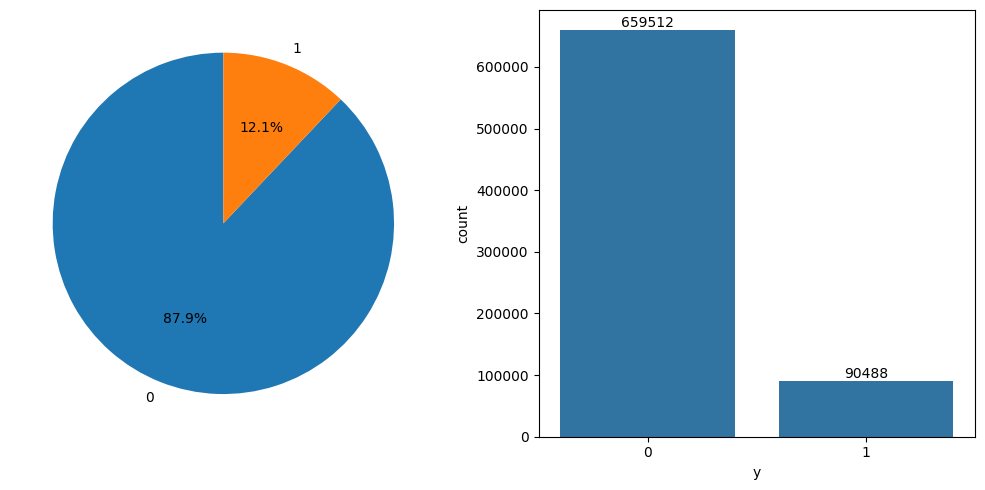

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

counts = df['y'].value_counts()
axs[0].pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)

ax = sns.countplot(x=df['y'], ax=axs[1])
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

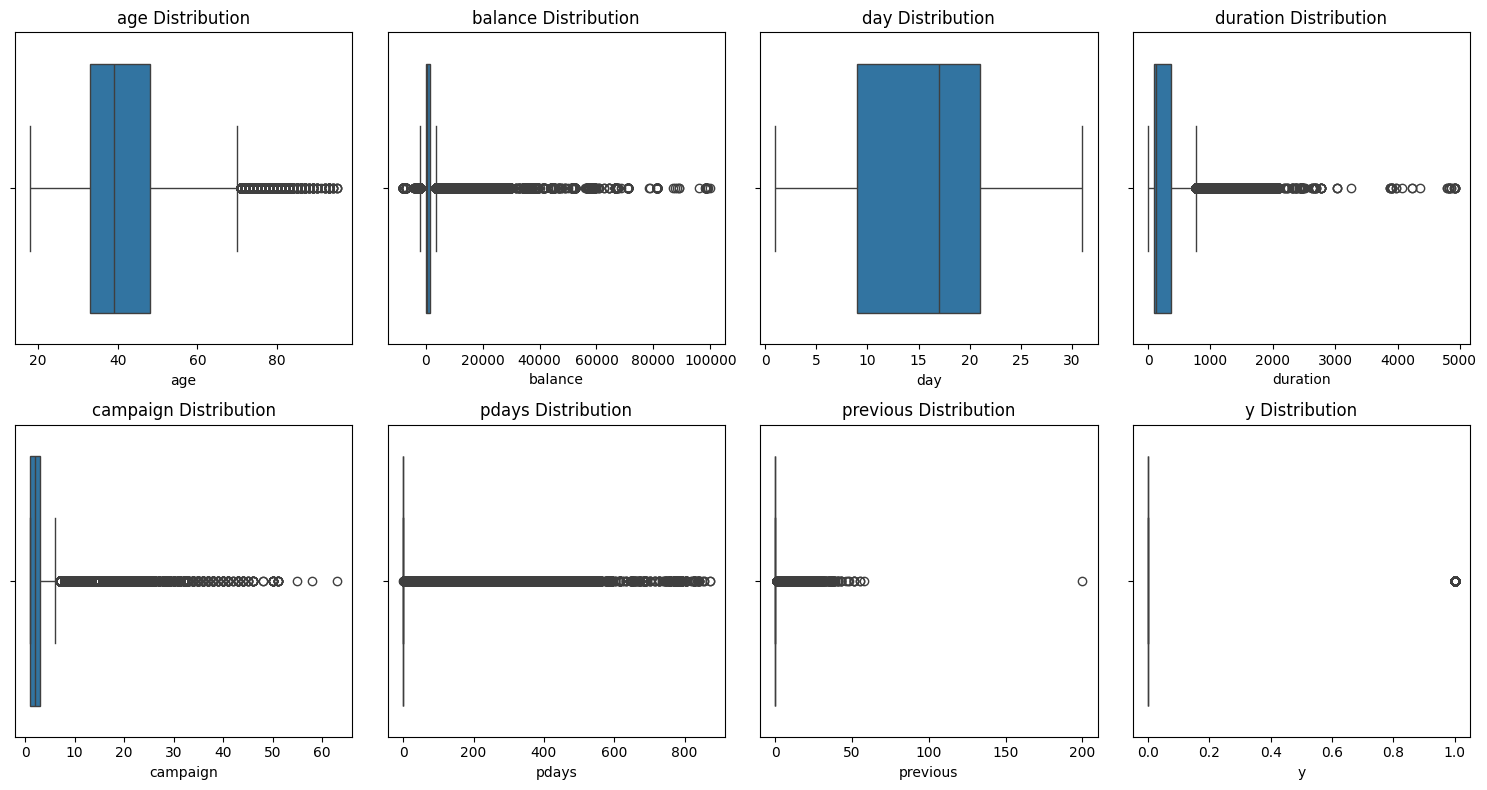

In [6]:
num = df.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15,8))
ax = axs.flatten()

for i,var in enumerate(num):
    sns.boxplot(x=df[var], ax=ax[i])
    ax[i].set_title(f'{var} Distribution')

fig.tight_layout()
plt.show()

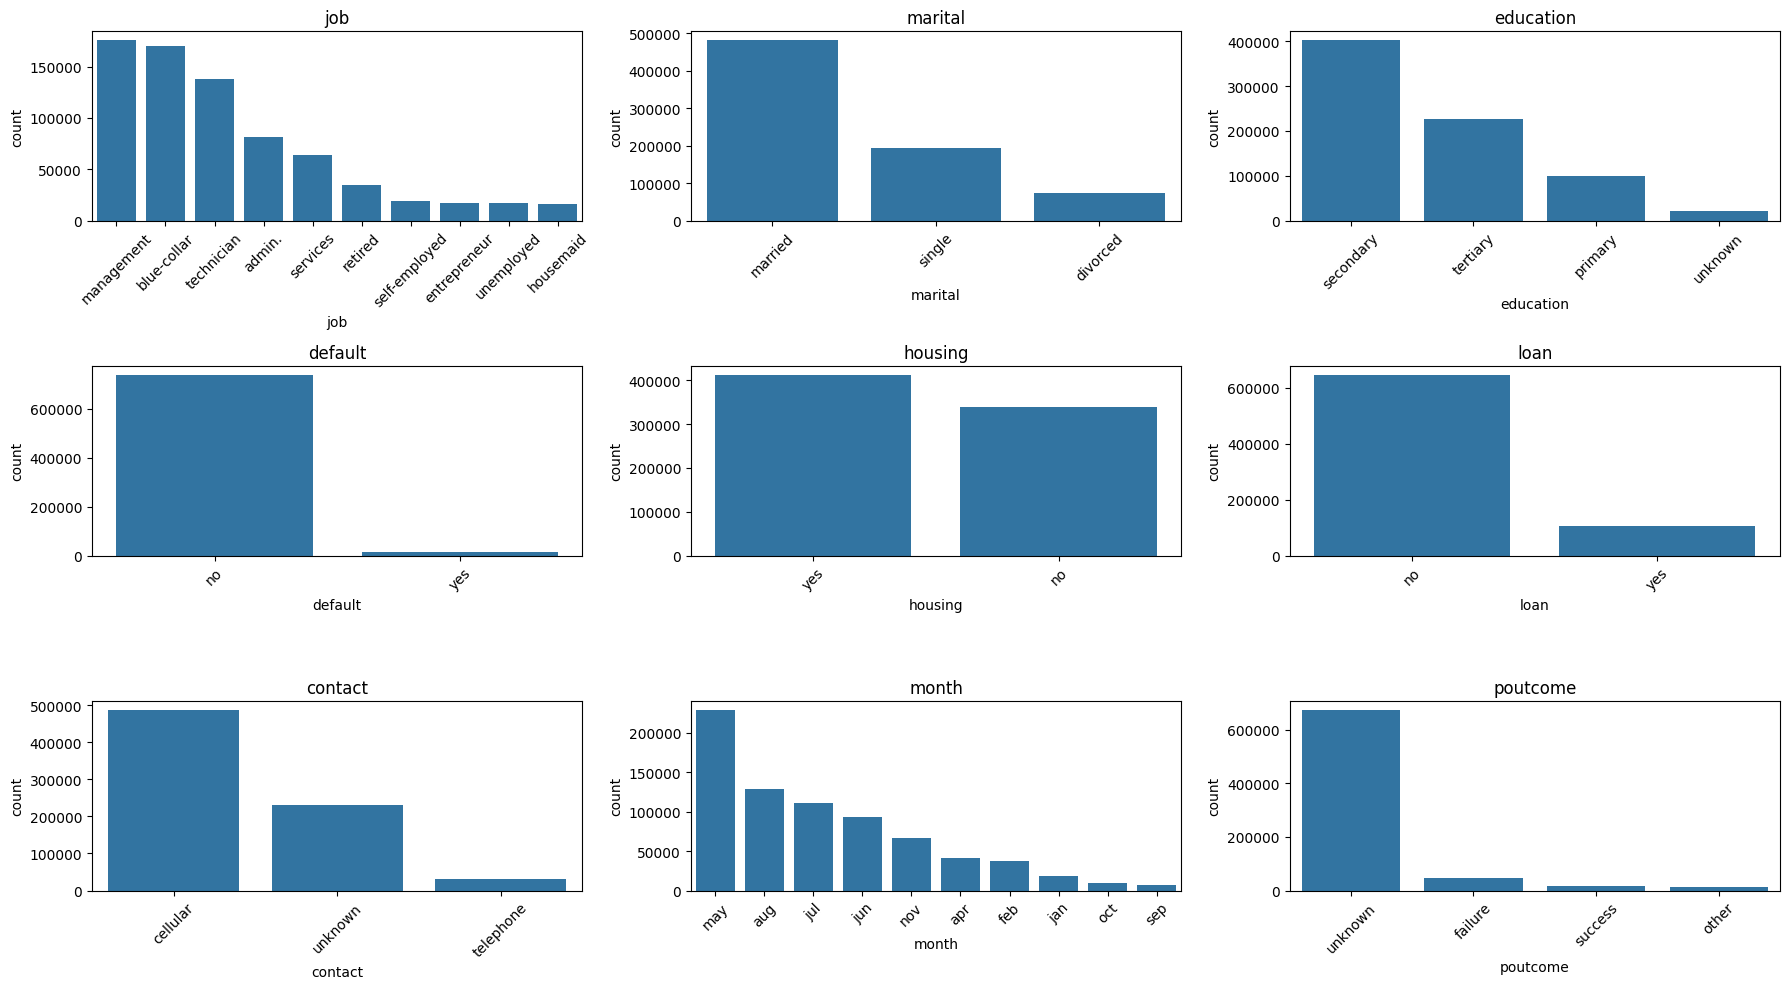

In [7]:
cat = df.select_dtypes(include='object').columns.tolist()
fig, axs = plt.subplots(3,3, figsize=(18,10))
ax = axs.flatten()

for i,var in enumerate(cat):
    vc = df[var].value_counts()
    if vc.shape[0] > 5:
        top_vals = vc.head(10).index
        sns.countplot(x=df[var][df[var].isin(top_vals)], ax=ax[i],
                      order=top_vals)
    else:
        sns.countplot(x=df[var], ax=ax[i], order=vc.index)
    ax[i].set_title(var)
    ax[i].tick_params(axis='x', rotation=45)

fig.tight_layout()
plt.show()

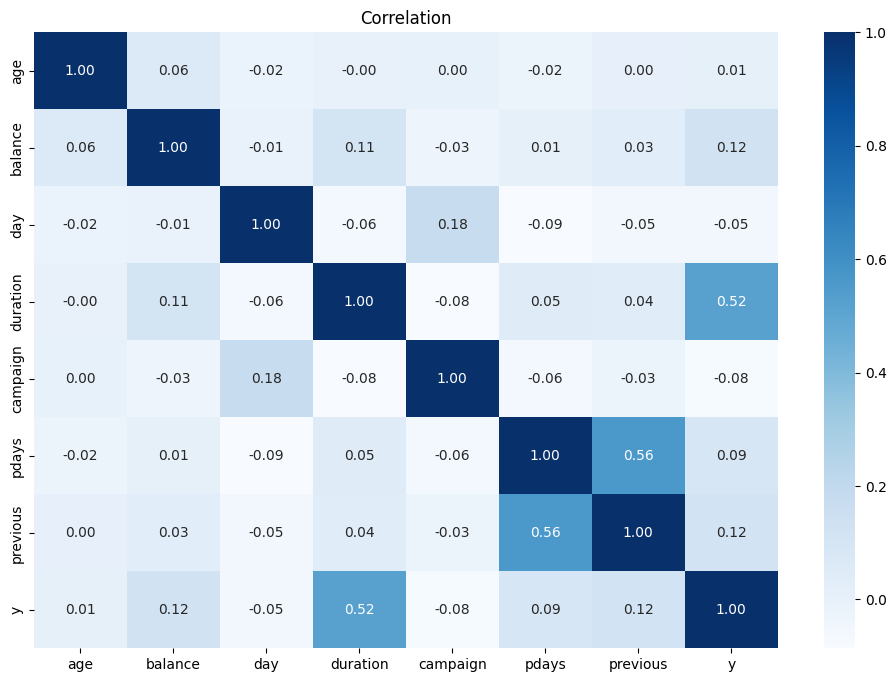

In [8]:
corr = df.drop('id', axis=1).select_dtypes(include='number').corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title("Correlation")
plt.show()

# Data Preprocessing

In [9]:
encoder = LabelEncoder()
cat_encoder = ['job', 'marital', 'contact', 'poutcome']

for i in cat_encoder:
    df[i] = encoder.fit_transform(df[[i]])

for i in cat_encoder:
    test[i] = encoder.fit_transform(test[[i]])

In [10]:
binary = ['default', 'housing', 'loan']

mapping = {'yes':1, 'no':0}

for i in binary:
    df[i] = df[i].map(mapping)

for i in binary:
    test[i] = test[i].map(mapping)

In [11]:
df['education'].unique()

array(['secondary', 'primary', 'tertiary', 'unknown'], dtype=object)

In [12]:
df = pd.get_dummies(df, columns=['education'], prefix='edu', dtype=int)
test = pd.get_dummies(test, columns=['education'], prefix='edu', dtype=int)

In [13]:
df['month'].unique()

array(['aug', 'jun', 'may', 'feb', 'apr', 'nov', 'jul', 'jan', 'oct',
       'mar', 'sep', 'dec'], dtype=object)

In [14]:
month_order = ['jan','feb','mar','apr','may','jun',
               'jul','aug','sep','oct','nov','dec']

df['month_num'] = df['month'].map({m: i+1 for i, m in enumerate(month_order)})
test['month_num'] = test['month'].map({m: i+1 for i, m in enumerate(month_order)})

In [15]:
df.drop('month', axis=1, inplace=True)
test.drop('month', axis=1, inplace=True)

In [16]:
X = df.drop(['id', 'y'], axis=1)
y = df['y']

# Machine Learning Model

## Baseline

In [17]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [18]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    gap = abs(train_acc - test_acc)

    if gap > 0.1:
        status = "Overfitting"
    elif gap < 0.02 and test_acc > 0.85:
        status = "Best"
    else:
        status = "Good"

    results.append([name, train_acc, test_acc, recall, precision, f1, auc, gap, status])

results = pd.DataFrame(results, columns=[
    "Model", "Train Accuracy", "Test Accuracy", "Recall", "Precision", "F1", "AUC", "Gap", "Status"
])

results

,Model,Train Accuracy,Test Accuracy,Recall,Precision,F1,AUC,Gap,Status
0,Logistic Regression,0.896607,0.896733,0.366394,0.622395,0.461255,0.893652,0.000127,Best
1,Random Forest,0.999983,0.931047,0.643054,0.749823,0.692347,0.962058,0.068937,Good
2,Gradient Boosting,0.926432,0.925387,0.579567,0.745381,0.652098,0.955991,0.001045,Best
3,XGBoost,0.939470,0.933700,0.655266,0.761902,0.704572,0.966069,0.005770,Best


## Hyper Parameter for Selected Model

In [ ]:
#xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
#parameter = {
    #'n_estimators': [100, 200, 300, 500],
    #'max_depth': [3, 5, 7, 9],
    #'learning_rate': [0.01, 0.05, 0.1, 0.2],
    #'subsample': [0.6, 0.8, 1.0],
    #'colsample_bytree': [0.6, 0.8, 1.0],
    #'gamma': [0, 1, 5],
    #'min_child_weight': [1, 3, 5]
#}

#random_search = RandomizedSearchCV(
    #estimator=xgb,
    #param_distributions=parameter,
    #n_iter=30,
    #scoring='precision',
    #cv=5,
    #verbose=2,
    #random_state=42,
    #n_jobs=-1
#)

# fit model
#random_search.fit(X_train, y_train)

# best model
#best_xgb = random_search.best_estimator_
#print("Best Parameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.8}


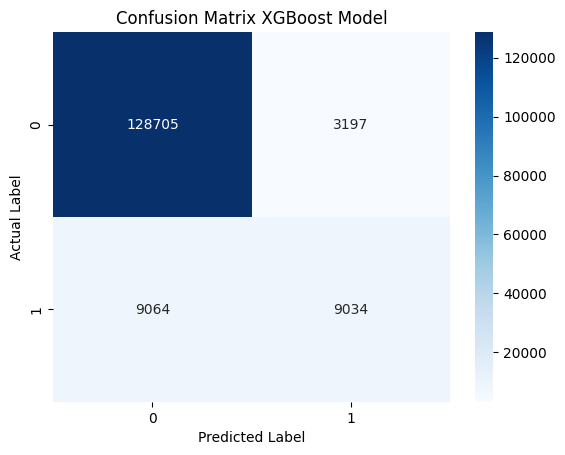

In [19]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, subsample=0.6, n_estimators=100,
                    min_child_weight=5, max_depth=3, learning_rate=0.05, gamma=0, colsample_bytree=1.0)
model = xgb.fit(X_train, y_train)
y_pred = model.predict(X_test)

#Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix XGBoost Model")
plt.show()

In [ ]:
#Count the accuracy score of the model
model_accuracy = accuracy_score(y_test, y_pred)

#Count the precison score of the model
model_precision = precision_score(y_test, y_pred)

#Count the recall score of the model
model_recall = recall_score(y_test, y_pred)

#Print the accuracy, precision, and recall score
print("Accuracy score of the XGBoost model =", round(model_accuracy*100,4), '%')
print("Precision score of the XGBoost model =", round(model_precision*100,4), '%')
print("Recall score of the XGBoost model =", round(model_recall*100, 4), '%')

Accuracy score of the XGBoost model = 91.826 %
Precision score of the XGBoost model = 73.8615 %
Recall score of the XGBoost model = 49.9171 %


## XGBoost Model After Applying Undersampling

In [20]:
rus = RandomUnderSampler(random_state=42)

#Applying undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

#Create a dataframe (df2) after the resampling
df2 = pd.DataFrame(X_resampled, columns=X.columns)
df2['y'] = y_resampled

In [21]:
X = df2.drop('y', axis=1)
y = df2['y']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

model = xgb.fit(X_train, y_train)

y_pred = model.predict(X_test)

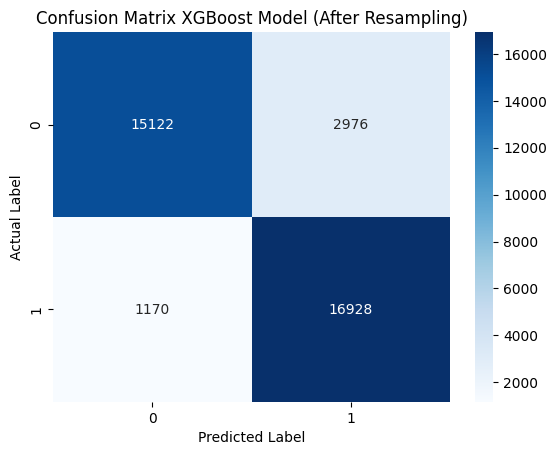

In [22]:
cm = confusion_matrix(y_test, y_pred)

#Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix XGBoost Model (After Resampling)")
plt.show()

In [ ]:
#Count the accuracy score of the model
model_accuracy = accuracy_score(y_test, y_pred)

#Count the precison score of the model
model_precision = precision_score(y_test, y_pred)

#Count the recall score of the model
model_recall = recall_score(y_test, y_pred)

#Print the accuracy, precision, and recall score
print("Accuracy score of the XGBoost model after resampling =", round(model_accuracy*100,4), '%')
print("Precision score of the XGBoost model after resampling=", round(model_precision*100,4), '%')
print("Recall score of the XGBoost model after resampling =", round(model_recall*100, 4), '%')

Accuracy score of the XGBoost model after resampling = 88.5457 %
Precision score of the XGBoost model after resampling= 85.0482 %
Recall score of the XGBoost model after resampling = 93.5352 %


## Features Important

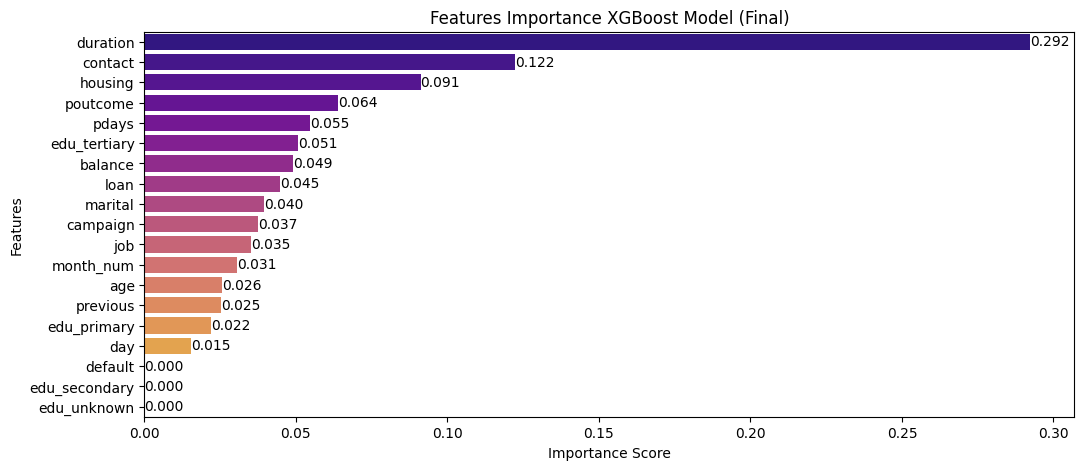

In [23]:
#Create a dataframe that performs features importance
fi = pd.DataFrame({'Features': X.columns, 'Importance Score': model.feature_importances_}).sort_values(by='Importance Score', ascending=False)

#Visualize the result
plt.figure(figsize=(12,5))
sns.barplot(fi, x='Importance Score', y='Features', palette='plasma')
for index, value in enumerate(fi['Importance Score']):
    plt.text(value, index, f'{value:.3f}', va='center')
plt.title("Features Importance XGBoost Model (Final)")
plt.show()

## Save the Model

In [ ]:
#Save the model
dump(model, '/content/drive/MyDrive/Dataset/best_model.joblib')

['/content/drive/MyDrive/Dataset/best_model.joblib']

## Make Predctions

In [24]:
X_test = test.drop('id', axis=1)

In [31]:
prob_pred = model.predict_proba(X_test)[:,1]

#Create the submission
submission = pd.DataFrame({
    'id': test['id'],
    'y': prob_pred
})

submission.to_csv('/content/drive/MyDrive/Dataset/submission.csv', index=False)
submission.head()

,id,y
0,750000,0.119498
1,750001,0.635233
2,750002,0.020614
3,750003,0.016992
4,750004,0.391254
